### **Time Series GAN**
-source: https://github.com/numancelik34/TimeSeries-GAN

In [124]:
# example of fitting an AUXULIARY CLASSIFIER gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

# mount from your google drive if your data located in your drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [9]:
df = pd.read_csv('outfinaltest890.csv', header=None, names=['A','B','Label'])

print(df.shape)
print(df['Label'].unique())
display(df.head())

(99999, 3)
[3 2 1 0]


,A,B,Label
0,0.0001,1.576538,3
1,0.0002,0.737152,3
2,0.0003,0.905151,3
3,0.0004,1.263733,3
4,0.0005,0.971985,3


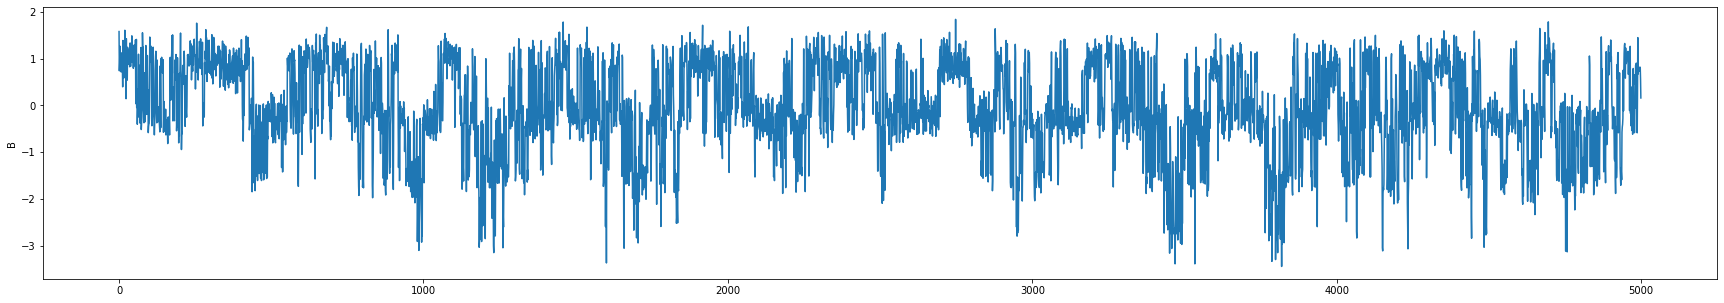

In [133]:
sample = df.iloc[0:5000,:]

pyplot.figure(figsize=(30,5))
sns.lineplot(x=sample.index, y='B', data=sample, hue=None)

#### **Define Generator and Discriminator**

In [10]:
# define the standalone discriminator model
def define_discriminator(in_shape=(384,1), n_classes=4):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    
    # image input
    in_image = Input(shape=in_shape)
    
    # downsample to 14x14
    fe = Conv1D(16, 3, strides=2, padding='same')(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    
    # normal
    fe = Conv1D(32, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    
    # downsample to 7x7
    fe = Conv1D(64, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    
    #downsample one more
    fe = Conv1D(128, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
   
    # flatten feature maps
    fe = Flatten()(fe)
    
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    
    # define model
    model = Model(in_image, [out1, out2])
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    # binary for real/fake loss; categorical for class label loss
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    model.summary()
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=4):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    depth = 32 
    ks = 3
    dropout = 0.25
    dim = 96 
    
    # label input
    in_label = Input(shape=(1,))
    
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    
    # linear multiplication
    n_nodes = 96 * 1
    li = Dense(n_nodes)(li)
    
    # reshape to additional channel
    li = Reshape((96, 1, 1))(li)
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    
    # foundation for 7x7 image
    n_nodes = dim*depth
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((dim, 1, depth))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, li]) #gen=96,1,32 x li=96,1,1
    
    # upsample to 192,1,16
    gen = Conv2DTranspose(16, 3, strides=(2,1), padding='same')(merge)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    #upsample to  384,1,8
    gen = Conv2DTranspose(8, 3, strides=(2,1), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    #updamsple
    #gen = Conv2DTranspose(48, (3,3), strides=(2,1), padding='same', kernel_initializer=init)(gen)
    #gen = BatchNormalization()(gen)
    #gen = Activation('relu')(gen)
    #384 x 1 property image
    gen = Reshape((384,-1))(gen)
    # upsample to 28x28
    #gen = Conv1DTranspose(1, 3, padding='same', kernel_initializer=init)(gen)
    gen = Conv1D(1, 3, strides=1, padding='same')(gen)
    
    out_layer = Activation('tanh')(gen)
    
    # define model
    model = Model([in_lat, in_label], out_layer)
    model.summary()
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

#### **Define Real Samples from Real Data**

In [52]:
# load images
def load_real_samples():
    # load dataset
    df29 = pd.read_csv('outfinaltest890.csv',header=None)
    
    # get only timeseries data values + class labels
    dataset=df29.values
    dataset = dataset.astype('float64')
    dataxy=dataset[:,1:]
    
    # make new array contains of value from first column
    timep=np.zeros([len(dataset),])
    timep=dataset[:,0]
    
    # get maximum value from class labels
    maxer=np.amax(dataset[:,2])
    print (maxer)
    
    # create maximum channel
    maxeri=maxer.astype('int')
    maxchannels=maxeri
    
    # make new array contains of value from class labels
    idataset=np.zeros([len(dataset),],dtype=int)
    idataset=dataset[:,2]
    idataset=idataset.astype(int)
    
    # split into data and label
    X_train = dataset[:,1]
    y_train = idataset[:]
    
    # data normalization and segmentation
    scaler = MinMaxScaler(copy=False)
    window=384
    n = ((np.where(np.any(dataxy, axis=1))[0][-1] + 1) // window) * window
    
    xx = scaler.fit_transform(dataxy[:n,0].reshape(-1,1))
    y_train = dataxy[:(n-window),1].reshape(-1,1)
    
    # make to matrix
    X_train = np.asarray([xx[i:i+window] for i in range (n - window)])
    #y_train = np.asarray([y_train[i:i+window] for i in range (n - window)])
    #trainX=X_train.copy()
    
    X = X_train.copy()
    y = y_train.copy()
    
    #X = xx.copy()
    #(trainXX, trainyy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    #X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    #X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    
    X = (X - 127.5) / 127.5
    print(X.shape, y.shape)
    
    return [X, y]

#### **Define Real and Fake Samples**

In [81]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    
    # select images and labels
    X, labels = images[ix], labels[ix]
    
    # generate class labels
    y = ones((n_samples, 1))
    
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=4):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    
    # generate random fake labels start from 0 to n_clasess as many as n_samples
    labels = randint(0, n_classes, n_samples) #check these labels!
    
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    
    # predict outputs
    images = generator.predict([z_input, labels_input])
    
    # create class labels
    y = zeros((n_samples, 1))
    
    return [images, labels_input], y

#### **Define Performance Summary**

In [88]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, nmn_label], nmn_y = generate_fake_samples(g_model, latent_dim, n_samples) #TODO!:Numan (nmns were _ and _) - change labels in this row and debug!
    
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        
        # turn off axis
        pyplot.axis('off')
        
        # plot raw pixel data
        pyplot.imshow(X[i, :], cmap='gray_r')
#         np.savetxt('test_raw_nc%d%d.csv' % (i,step), X[i,:], delimiter=',')
#         np.savetxt('test_cat_nc%d%d.csv' % (i,step), nmn_label[i],delimiter=',')
    
    # save plot to file
    #np.savetxt('test_raw_nc%d.csv' % (step), X[:,:,0], delimiter=',')
    #np.savetxt('test_cat_nc%d.csv' % (step), nmn_label[:],delimiter=',')
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))
    print('success')

#### **Training AC-GAN**

In [86]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_evals=100):
    
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    print('batch per epoch: %d' % bat_per_epo)
    
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print('number of steps: %d' % n_steps)
    
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        
        
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        
        
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        
        
        # summarize loss on this batch
        if (i+1) % n_evals == 0:
            print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

In [89]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()

# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 384, 1)       0                                            
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 192, 16)      64          input_16[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_36 (LeakyReLU)      (None, 192, 16)      0           conv1d_26[0][0]                  
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 192, 16)      0           leaky_re_lu_36[0][0]             
___________________________________________________________________________________________

/home/furanzu/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/furanzu/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/furanzu/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>100, dr[0.775,1.432], df[0.735,1.563], g[0.797,1.496]
>200, dr[0.155,1.301], df[0.290,0.340], g[1.932,0.387]
>300, dr[0.144,1.351], df[0.148,0.062], g[2.709,0.047]
>400, dr[0.224,1.300], df[0.192,0.335], g[1.581,0.107]
>500, dr[0.201,1.232], df[0.148,0.035], g[1.081,0.141]
>600, dr[0.396,1.218], df[0.175,0.034], g[0.646,0.168]
>700, dr[0.514,1.187], df[0.454,0.070], g[0.609,0.229]
>800, dr[0.908,1.053], df[1.120,0.142], g[0.978,0.226]
>900, dr[0.712,1.080], df[0.917,0.098], g[0.614,0.171]
>1000, dr[0.673,1.284], df[0.802,0.072], g[0.790,0.096]
>1100, dr[0.692,1.157], df[0.722,0.066], g[0.736,0.085]
>1200, dr[0.735,1.514], df[0.732,0.066], g[0.759,0.213]
>1300, dr[0.834,1.193], df[0.697,0.063], g[0.744,0.054]
>1400, dr[0.757,1.212], df[0.733,0.046], g[0.744,0.028]
>1500, dr[0.731,1.340], df[0.753,0.051], g[0.800,0.050]
>Saved: generated_plot_1554.png and model_1554.h5
success
>1600, dr[0.729,0.904], df[0.689,0.082], g[0.829,0.050]
>1700, dr[0.678,1.315], df[0.637,0.036], g[0.751,0.035]